# 1. Create master bias

The first step in data redution is to combine all the individual `raw_bias_exposures` in the `raw_bias_folder` directory to create a single `master_bias` and save it as a FITS file called `master_bias_filename`.

## Initialise parameters

In [34]:
import os  # to manipulate files and directories
import numpy as np  # mathematics
from astropy.io import fits  # FITS files
from matplotlib import pyplot as plt  # plotting

data_folder = '.'  # location of the observational data within your hard disk (by default, this directory)
raw_bias_folder = os.path.join(data_folder, 'raw', 'bias')  # location of the bias file
output_filename = os.path.join(data_folder, 'reduced', 'master_bias.fits')  # name of the file where you intend to save the master bias

## Read raw exposures

In [28]:
raw_bias_exposures = []  # List containing all individual exposures

for filename in os.listdir(raw_bias_folder):  # Loop over all files in the directory
    
    if os.path.splitext(filename)[1] == '.fits':  # FITS file extension
        print("Opening", filename)
        hdu = fits.open(os.path.join(raw_bias_folder, filename))  # HDU = Header/Data Unit (standard FITS nomenclature)
        raw_bias_exposures.append(hdu[0].data)  # Add the data to the `raw_exposures` list
        '''
        TODO:
        - Check that t_exp > 0
        - show individual exposures?
        - Comprobar si hay que recortar
        if data.shape != image_header.im_size:
            # Recortar donde sabemos que está la imagen:           
            data = recortadora(data, image_header.data_cut, image_header.im_size, bias_header.data_cut)
        '''
    else:
        print("Skipping", filename)

n_files = len(raw_bias_exposures)
print(n_files, "files read")

Opening uamA_0002.fits
Skipping .DS_Store
Opening uamA_0001.fits
2 files read


## Compute bias

If there is just one bias exposure, there is not much to do: that is the bias map. If there are more than two, ... (TODO: explanation)

In [32]:
if n_files == 0:
    raise FileNotFoundError("No FITS files were found in "+raw_bias_folder)

else:
    bias_map = np.nanmedian(raw_bias_exposures, axis=0)

    if n_files == 1:
        print("WARNING: only one bias file was found.")

    else:
        noise_map = np.nanvar(raw_bias_exposures, axis=0)
    
        # Test whether the median bias map is uniform
        map_median = np.nanmedian(bias_map)  # estimate of a uniform value accross the image
        map_variance = np.nanvar(bias_map)  # map_variance = signal_variance + noise_variance
        noise_variance = np.nanmedian(noise_map)  # estimator of the typical noise variance
        signal_variance = map_variance - noise_variance
        if signal_variance <= 0.:
            probability_uniform = 1.
        else:
            probability_uniform = np.exp(-signal_variance/noise_variance)
        uniform = map_median*np.ones_like(bias_map)
        bias_map = probability_uniform*uniform + (1-probability_uniform)*bias_map  # weighted average

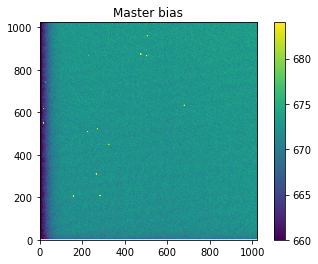

In [33]:
# TODO: Proper plots
plt.imshow(bias_map, origin='lower', vmin=np.nanpercentile(bias_map, 5), vmax=np.nanpercentile(bias_map, 95))
plt.title('Master bias')
plt.colorbar()
plt.show()

In [30]:
hdu = fits.PrimaryHDU(bias_map)
hdu.writeto(output_filename, overwrite=True)
print("Master bias saved to", output_filename)

Master bias saved to ./reduced/master_bias.fits
